# Echo State Networks
This notebook illustrates the use of this ESN library by an example. The goal will be to forecast air quality measurements.


### Import Libraries

In [1]:
import sys, os, ssl
sys.path.append(os.path.join(os.getcwd(), "..", "Source"))

import EchoStateNetworks
from dataUtils import Data

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler


from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

### Load and Scale Data
ESNs work best when the data is scaled on an intervall around zero e.g. (0,1) or (-1, 1). You could either pass the respective input shift, input scaling and input mask or scale the date beforehand.

In [3]:
def fetch_data():
    # Load data, if csv doesn't exist
    ssl._create_default_https_context = ssl._create_unverified_context
    url = r'https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip'
    zip_archive = urlopen(url)
    
    csv_data = ZipFile(BytesIO(zip_archive.read())).extract('AirQualityUCI.csv')
    data = pd.read_csv(csv_data, sep=";")
    return data

def load_data(path=None):
    # Load data from csv oder fetch it online
    try:
        data = pd.read_csv(path, sep=";", header=[0])
        print("Data loaded from csv")
    except FileNotFoundError:
        data = fetch_data()
        print("Data loaded from the web")
        
    data = data.dropna(axis='index', how='all')
    data = data.drop(['Unnamed: 15','Unnamed: 16'], axis=1)
    return data

Data loaded from csv


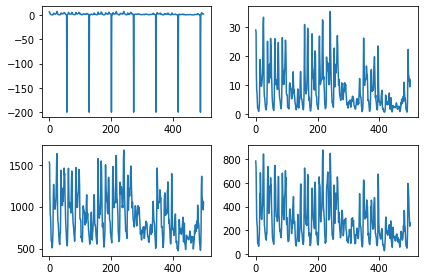

In [4]:
data_raw = load_data(os.path.join(os.getcwd(), "AirQualityUCI.csv"))

data = Data(model_input=data_raw[["CO(GT)", "C6H6(GT)", "PT08.S2(NMHC)", "NOx(GT)"]], 
            model_output=data_raw[["CO(GT)", "C6H6(GT)", "PT08.S2(NMHC)", "NOx(GT)"]])
data.split_data_by_index(8000)
data.visualize()

scaler = MinMaxScaler(feature_range=(0, 1))
data.scale_data(scaler) 

### Initialize and train Echo State Network

In [5]:
my_esn = EchoStateNetworks.EchoStateNetwork(no_input_nodes=4, 
                                                no_output_nodes=4,
                                                no_internal_nodes=200,
                                                spectral_radius=1.2,
                                                regression_lambda=0.02,
                                                connectivity=0.05)
print(my_esn)

Name		ESN_model
No. Inputs	4
No. Outputs	4
Reservoir Size	200
Spectral Radius	1.2
Reg. Lambda	0.02
Input Shift 	0.0
Input Scaling	1.0
Connectivity	0.05
Trained		False


#### Visualize Fit on the Training Set
Hyperparamter are not optimized

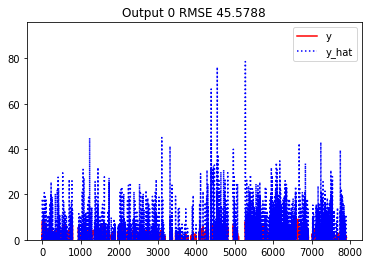

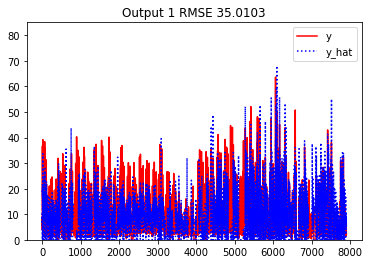

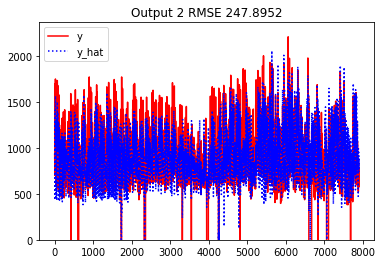

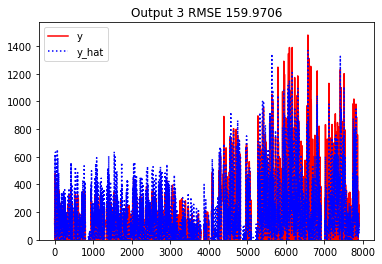

In [6]:
my_esn.fit(data, no_forget_points=100)
y_hat, y_train = my_esn.visualize_fit(data.x_train, data.y_train, data.scaler)

#### Visualize Fit on the Test Set
The charts below show a single 30-day ahead forecast for each time series. (To be improved)

In [7]:
multi_step_forecast, actual = my_esn.forecast(data=data, forecast_horizon=30, no_samples=10)

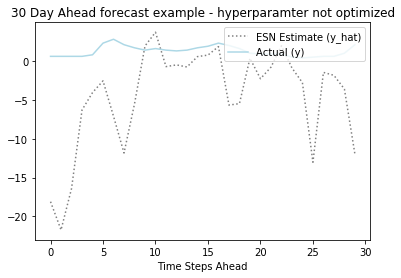

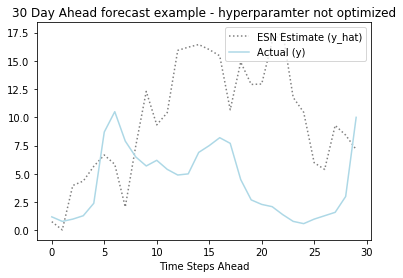

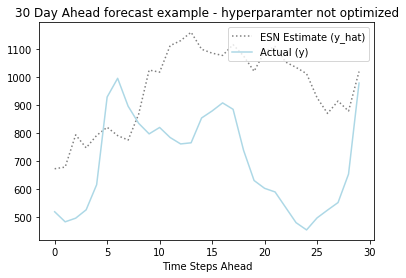

In [8]:
for i in [0,1,2]:
    plt.plot(multi_step_forecast[:,i], linestyle=":", label="ESN Estimate (y_hat)", color = "grey")
    plt.plot(actual[:,i], label="Actual (y)", color="lightblue")
    plt.xlabel("Time Steps Ahead")
    plt.legend(loc=1)
    plt.title("30 Day Ahead forecast example - hyperparamter not optimized")
    plt.show()

#### Optimize Hyperparamter
The variable "test_paramter" determines the hyperparamter space. The format is {"parameter_name": Min (incl.), Max(incl.), Steps}. The algorithm then tries to minize the error on the training set. Determined by "split_index".
Bayesain optimization methods are also availabe. 

In [9]:
test_parameter = {
"internal_nodes": (30, 100, 3),
"spectral_radius": (0.1, 1.2, 3),
"regression_lambda": (1, 1e-10, 3),
"connectivity": (0.01, 0.5, 3)}

EchoStateNetworks.hyper_parameter_grid_search(data=data,split_index=8000, 
                                              hyper_parameter_space=test_parameter, 
                                              show_status=True)

Run Grid Search
 1  0.01 30.00 1.00 0.10  Error: 202.8597 Global Optimum: 202.8597
 2  0.01 30.00 1.00 0.65  Error: 202.8491 Global Optimum: 202.8491
 3  0.01 30.00 1.00 1.20  Error: 202.8377 Global Optimum: 202.8377
 4  0.01 30.00 0.50 0.10  Error: 202.8594 Global Optimum: 202.8377
 5  0.01 30.00 0.50 0.65  Error: 202.8414 Global Optimum: 202.8377
 6  0.01 30.00 0.50 1.20  Error: 202.8289 Global Optimum: 202.8289
 7  0.01 30.00 0.00 0.10  Error: 203.1426 Global Optimum: 202.8289
 8  0.01 30.00 0.00 0.65  Error: 207.3892 Global Optimum: 202.8289
 9  0.01 30.00 0.00 1.20  Error: 203.2663 Global Optimum: 202.8289
 10  0.01 65.00 1.00 0.10  Error: 202.8558 Global Optimum: 202.8289
 11  0.01 65.00 1.00 0.65  Error: 202.8235 Global Optimum: 202.8235
 12  0.01 65.00 1.00 1.20  Error: 202.8195 Global Optimum: 202.8195
 13  0.01 65.00 0.50 0.10  Error: 202.8520 Global Optimum: 202.8195
 14  0.01 65.00 0.50 0.65  Error: 202.8197 Global Optimum: 202.8195
 15  0.01 65.00 0.50 1.20  Error: 202.818

(202.013355194907,
 {'connectivity': 0.5,
  'regression_lambda': 0.50000000005,
  'spectral_radius': 1.2,
  'internal_nodes': 100})

### Data
The data comes from the [UCI Machine Learning Respository](https://archive.ics.uci.edu/ml/index.php). 

The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. 
Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008  eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value.
This dataset can be used exclusively for research purposes. Commercial purposes are fully excluded.